# Problem Description

I was inspired by some research i did in my undergrad in astrophysics which was Star classification. Our team actually had a Kaggle competition which you can find here: https://www.kaggle.com/competitions/PLAsTiCC-2018/overview. The resulting model is called astrorapid found here: https://astrorapid.readthedocs.io/en/latest/index.html.  I would have completed this competition, however, i need to upgrade the storage on my PC as the dataset there is 40GB and i have less than 5GB available. So i am restricted to smaller datasets. The problem i found was predicting what spectral class a star belongs to given data about each star.

Given a dataset of stars with labels, predict what spectral class the star belongs to. Here are some of the data points:


Absolute Temperature (in K)
Relative Luminosity (L/Lo)
Relative Radius (R/Ro)
Absolute Magnitude (Mv)
Star Color (white,Red,Blue,Yellow,yellow-orang
Star Type (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants)e etc)
Spectral Class (O,B,,F)iants)**

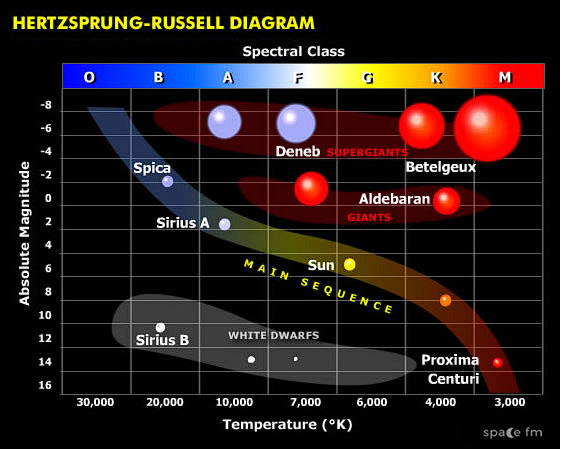

# EDA

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.metrics import accuracy_score

In [2]:
# Check for any missing values in the dataset
stars_df = pd.read_csv('./6 class csv.csv')
print(stars_df.head)
missing_values = stars_df.isnull().sum()

# Encoding the categorical features 'Star color' and 'Spectral Class'
stars_df_encoded = pd.get_dummies(stars_df, columns=['Star color'], drop_first=True)
spectral_class_mapping = {label: idx for idx, label in enumerate(set(stars_df_encoded['Spectral Class']))}
stars_df_encoded['Spectral Class'] = stars_df_encoded['Spectral Class'].map(spectral_class_mapping)

print(missing_values)

print("Spectral Class Mappings:")
print(spectral_class_mapping)

<bound method NDFrame.head of      Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0               3068          0.002400        0.1700                   16.12   
1               3042          0.000500        0.1542                   16.60   
2               2600          0.000300        0.1020                   18.70   
3               2800          0.000200        0.1600                   16.65   
4               1939          0.000138        0.1030                   20.06   
..               ...               ...           ...                     ...   
235            38940     374830.000000     1356.0000                   -9.93   
236            30839     834042.000000     1194.0000                  -10.63   
237             8829     537493.000000     1423.0000                  -10.73   
238             9235     404940.000000     1112.0000                  -11.23   
239            37882     294903.000000     1783.0000                   -7.80   

     Star

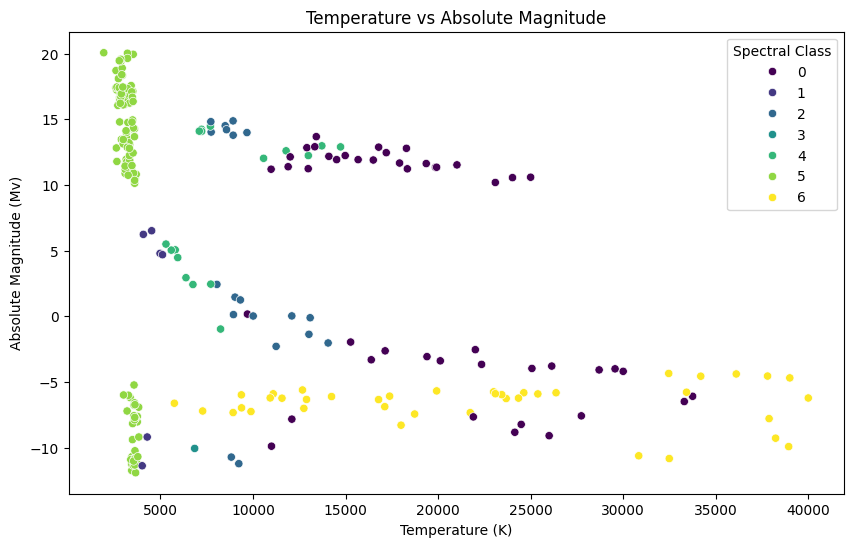

In [3]:
# Plotting Temperature vs Absolute Magnitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature (K)', y='Absolute magnitude(Mv)', hue='Spectral Class', data=stars_df_encoded, palette='viridis')
plt.title('Temperature vs Absolute Magnitude')
plt.xlabel('Temperature (K)')
plt.ylabel('Absolute Magnitude (Mv)')
plt.show()

In [4]:
statistics = stars_df_encoded.describe()
statistics

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Spectral Class
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,3.791667
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,2.172078
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,2.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,5.000000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,5.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000,6.000000


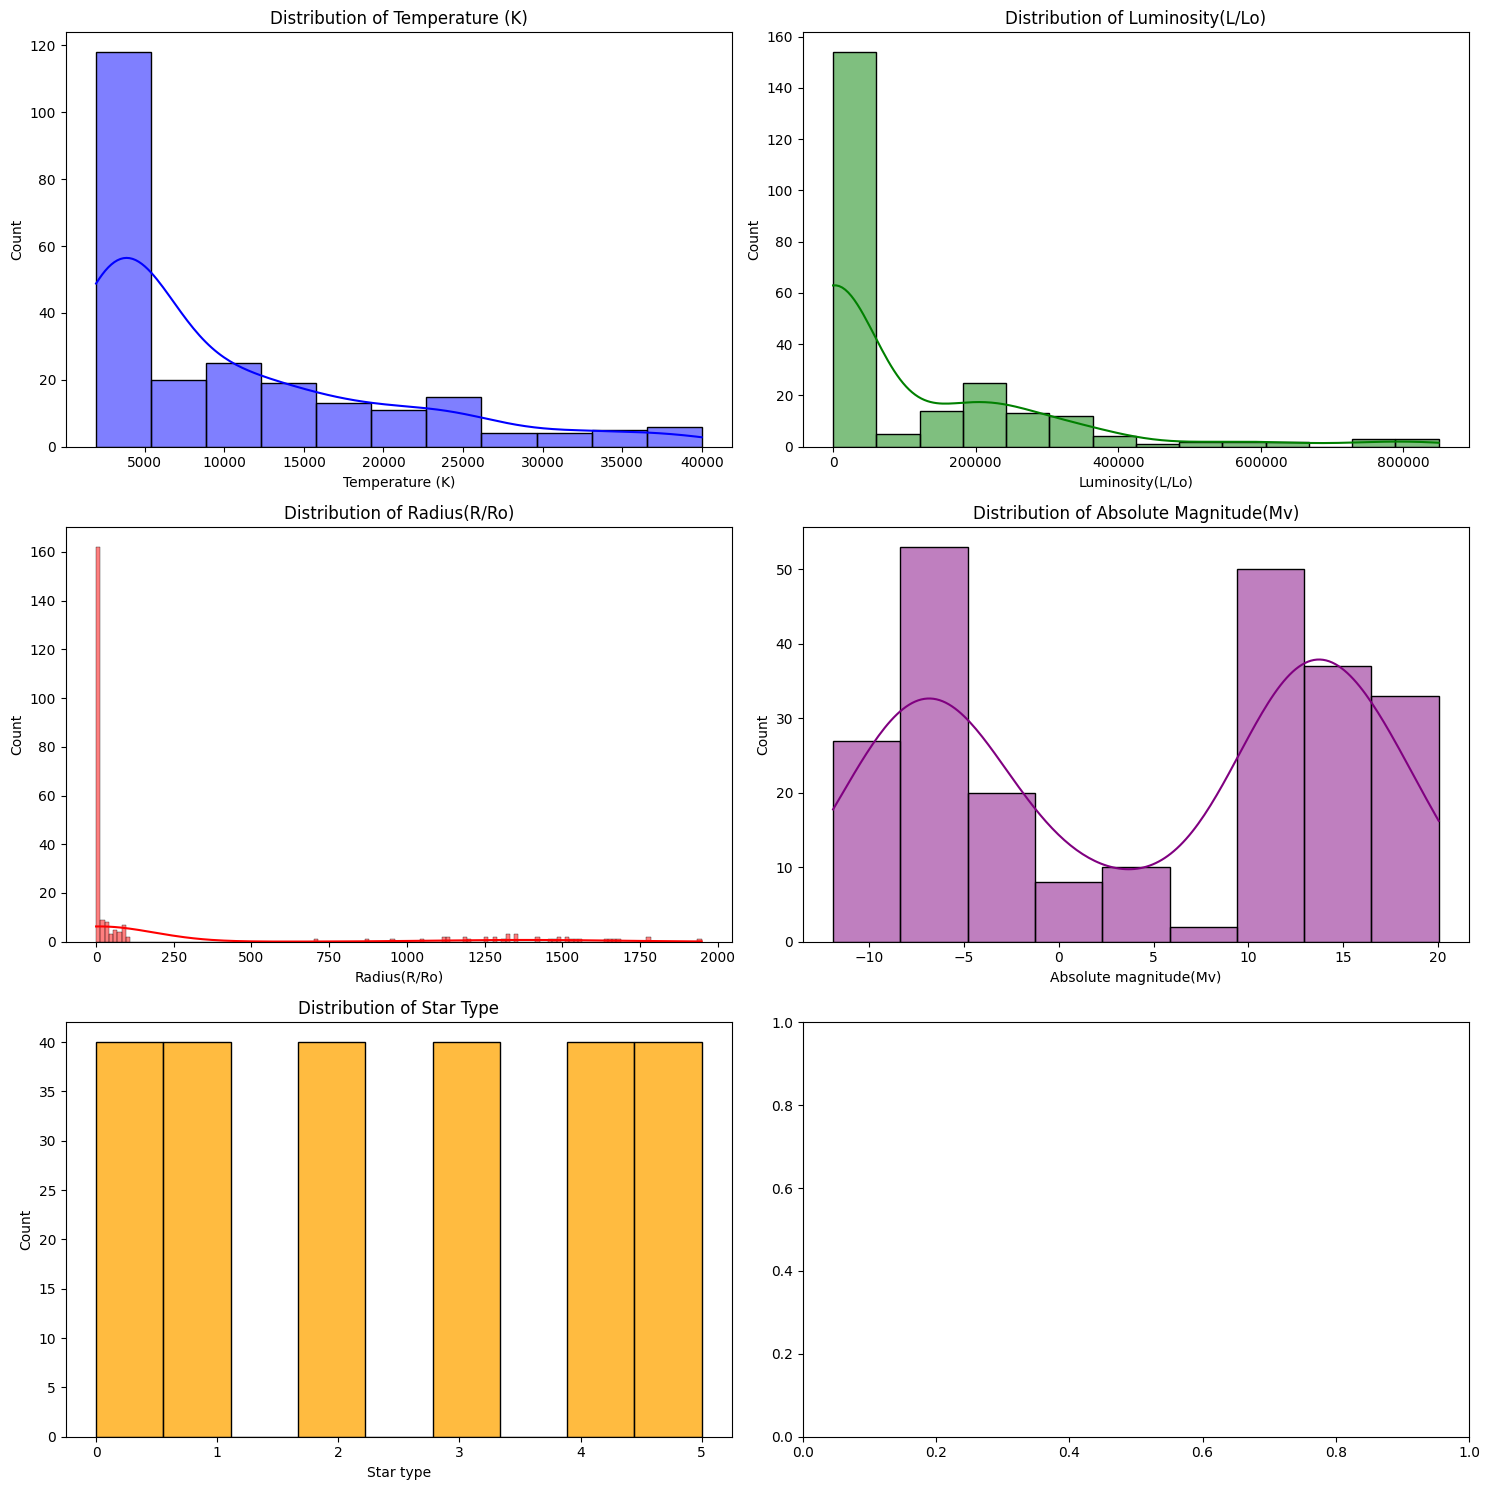

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

sns.histplot(stars_df_encoded['Temperature (K)'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Distribution of Temperature (K)')

sns.histplot(stars_df_encoded['Luminosity(L/Lo)'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Distribution of Luminosity(L/Lo)')

sns.histplot(stars_df_encoded['Radius(R/Ro)'], kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Distribution of Radius(R/Ro)')

sns.histplot(stars_df_encoded['Absolute magnitude(Mv)'], kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Distribution of Absolute Magnitude(Mv)')

sns.histplot(stars_df_encoded['Star type'], kde=False, ax=axes[2, 0], color='orange')
axes[2, 0].set_title('Distribution of Star Type')

plt.tight_layout()
plt.show()

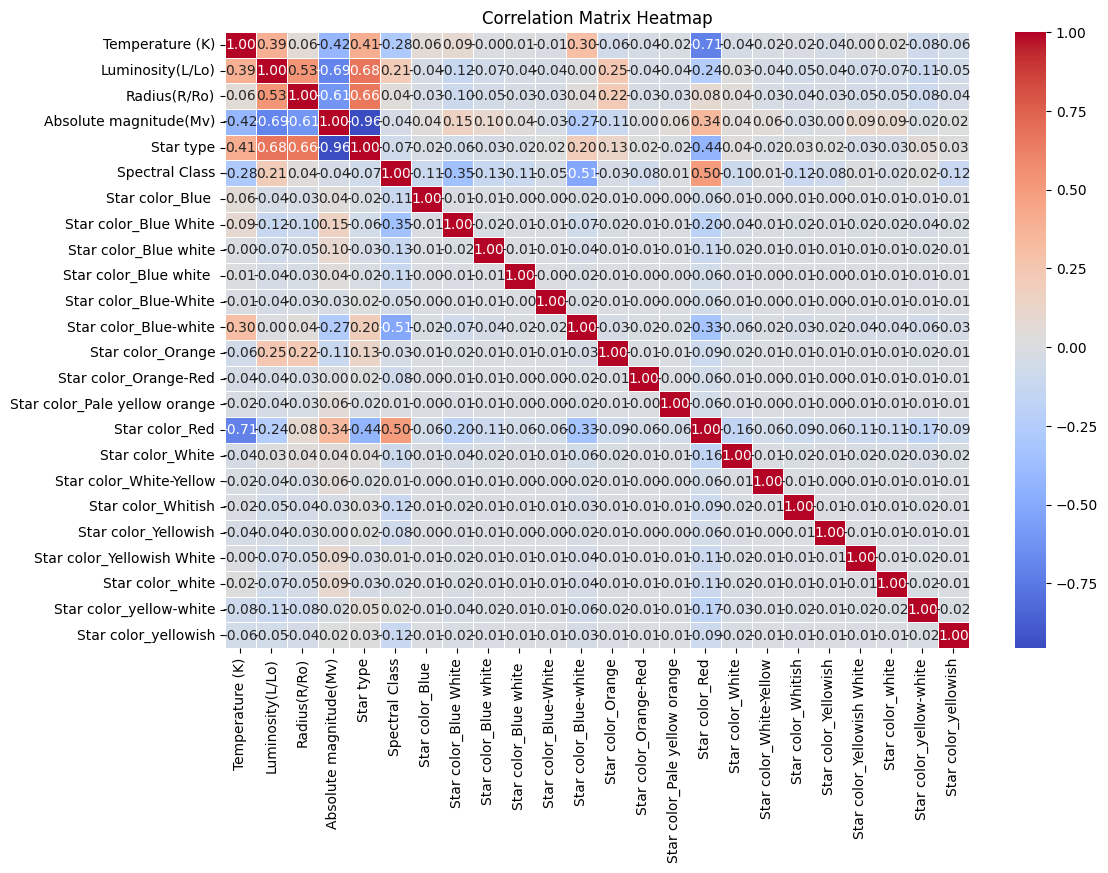

In [6]:
corr = stars_df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# EDA Comments

First thing i notice is 0 missing values. That's awesome. For categorical data we encode them either as one hot encoding or label encoding. The plot of our Hertzsprung-Russell Diagram is a little unexpected but hey that's good for the model. We'll see if it can predict. Also notice that there are exactly the same number of star types. This dataset is originally made for that to be the target variable but i decided to switch things up. There is a strong negative correlation between star type and absolute magnitude. As for our target, spectral class, it seems to be fairly uncorrelated except for the highest with Luminosity.

# Model Building

Let's start with a simple Neural Network architecture. Our data isnt big or complex so we probably wont need much. First though, we normalize for the model

In [7]:
X = stars_df_encoded.drop('Spectral Class', axis=1)
y = stars_df_encoded['Spectral Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_categorical = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=0)

In [8]:
def build_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [25]:
starter_model = build_model()
history = starter_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
test_loss, test_accuracy = starter_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/100


6/6 [==============================] - 2s 79ms/step - loss: 1.6877 - accuracy: 0.4375 - val_loss: 1.6967 - val_accuracy: 0.4167
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 1.5129 - accuracy: 0.5104 - val_loss: 1.5342 - val_accuracy: 0.4792
Epoch 3/100
6/6 [==============================] - 0s 16ms/step - loss: 1.3575 - accuracy: 0.6406 - val_loss: 1.3880 - val_accuracy: 0.7083
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 1.2243 - accuracy: 0.7083 - val_loss: 1.2627 - val_accuracy: 0.7500
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1025 - accuracy: 0.7656 - val_loss: 1.1586 - val_accuracy: 0.7917
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.9972 - accuracy: 0.7917 - val_loss: 1.0657 - val_accuracy: 0.7708
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9002 - accuracy: 0.8073 - val_loss: 0.9871 - val_accuracy: 0.7708
Epoch 8/100
6/6 [===

Wow our starter model worked pretty well the first try! Let's run this model at a few different epochs and compare the performance!

Epochs: 100, Test Accuracy: 0.9583333134651184
Epochs: 150, Test Accuracy: 0.9166666865348816
Epochs: 200, Test Accuracy: 0.9375
Epochs: 250, Test Accuracy: 0.9583333134651184
Epochs: 300, Test Accuracy: 0.9166666865348816
Epochs: 400, Test Accuracy: 0.8958333134651184
Epochs: 500, Test Accuracy: 0.9166666865348816


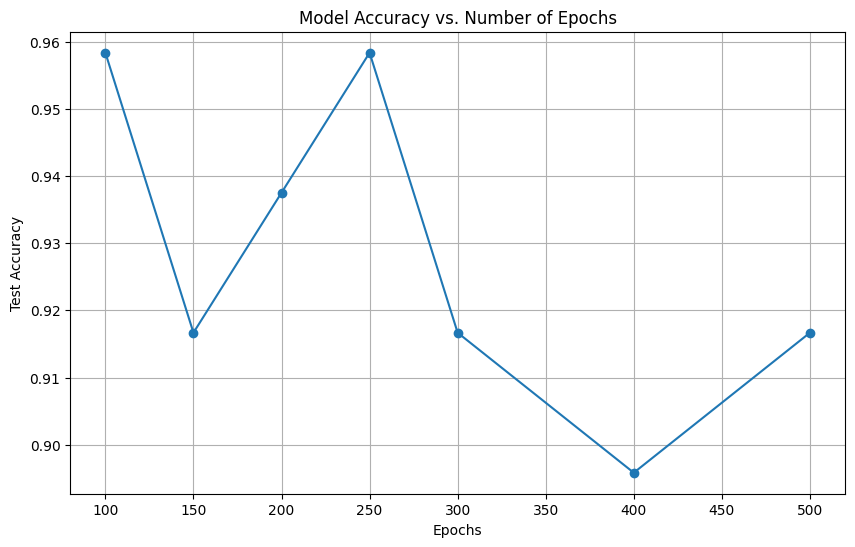

In [26]:
epoch_values = [100, 150, 200, 250, 300, 400, 500]  # List of epoch values to test
accuracies = []

for epochs in epoch_values:
    model = build_model()

    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(test_accuracy)
    print(f"Epochs: {epochs}, Test Accuracy: {test_accuracy}")

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(epoch_values, accuracies, marker='o')
plt.title('Model Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

# Tuning

Let's tune the model by running a grid search varying the neurons in each layer, the activation, and the learning rate of the Adam optimizer.

In [20]:
def build_tuning_model(neurons1=64, neurons2=32, activation='relu', learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons1, input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Dense(neurons2))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

def grid_search(params, X_train, y_train, X_test, y_test):
    param_combinations = [dict(zip(params, v)) for v in itertools.product(*params.values())]

    best_score = 0
    best_params = None

    for param in param_combinations:
        print(f"Testing with parameters: {param}")

        model = build_tuning_model(**param)
        model.fit(X_train, y_train, batch_size=16, epochs=250, verbose=0)

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)
        score = accuracy_score(y_true, y_pred_classes)

        print(f"Accuracy: {score}")

        if score > best_score:
            best_score = score
            best_params = param

    print(f"Best score: {best_score}")
    print(f"Best parameters: {best_params}")

    return best_score, best_params
    
grid = {
    'neurons1': [128, 64, 32, 16, 8],
    'neurons2': [128, 64, 32, 16, 8],
    'activation': ['relu', 'softmax', 'swish'],
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],    
}

grid_search(grid, X_train, y_train, X_test, y_test)

Testing with parameters: {'neurons1': 128, 'neurons2': 128, 'activation': 'relu', 'learning_rate': 0.01}
2/2 [==============================] - 0s 6ms/step
Accuracy: 0.8958333333333334
Testing with parameters: {'neurons1': 128, 'neurons2': 128, 'activation': 'relu', 'learning_rate': 0.001}
2/2 [==============================] - 0s 2ms/step
Accuracy: 0.9166666666666666
Testing with parameters: {'neurons1': 128, 'neurons2': 128, 'activation': 'relu', 'learning_rate': 0.0001}
2/2 [==============================] - 0s 2ms/step
Accuracy: 0.9166666666666666
Testing with parameters: {'neurons1': 128, 'neurons2': 128, 'activation': 'relu', 'learning_rate': 1e-05}
2/2 [==============================] - 0s 29ms/step
Accuracy: 0.8958333333333334
Testing with parameters: {'neurons1': 128, 'neurons2': 128, 'activation': 'softmax', 'learning_rate': 0.01}
2/2 [==============================] - 0s 3ms/step
Accuracy: 0.9166666666666666
Testing with parameters: {'neurons1': 128, 'neurons2': 128, 'activa

(0.9583333333333334,
 {'neurons1': 128,
  'neurons2': 64,
  'activation': 'softmax',
  'learning_rate': 0.01})

In [26]:
best_params = {
  'neurons1': 128,
  'neurons2': 64,
  'activation': 'softmax',
  'learning_rate': 0.01,
}
best_model = build_tuning_model(**best_params)
best_model.fit(X_train, y_train, batch_size=16, epochs=250, verbose=0)

y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred_classes)

print(f"Accuracy: {score}")

2/2 [==============================] - 0s 23ms/step
Accuracy: 0.9375


# Results

After the grid search, the best parameters appeared to be 'neurons1': 128, 'neurons2': 64,'activation': 'softmax', 'learning_rate': 0.01, with an accuracy of 0.958333 during training and 0.9375 during validation. However, i know a few models with the same accuracy, but we pick the one the grid search returned. 

# Conclusion

An accuracy of 94% is pretty good given the fact that our dataset is super tiny (240 stars). If we had more stars or more data on each star, we could make our model more complex and probably see results over 99%. I did not find a larger dataset that was this good unfortunately. However, given the quality of the dataset, as seen in EDA, i am satisified with the results of having 96% accuracy, especially with a simple model (this was nothing like the GAN assignment lol).

Overall, i am curious about the performance of this model on larger datsets, and to see if training the model also increases that performance level.